# 🔬 Docking croisé + Visualisation

In [2]:
import os, time, re
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def extract_affinity_from_log(log_file):
    affinity, found = None, False
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if found and re.match(r'^\s*1\s+-?\d+\.\d+', line):
                    affinity = float(line.split()[1])
                    break
                if line.strip().startswith("mode |"):
                    found = True
    except Exception:
        pass
    return affinity

def run_docking_fallback(ligand_pdbqt, receptor, output_dir, try_tools=["smina", "vina"]):
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.basename(ligand_pdbqt).replace('.pdbqt', '')
    output_file = os.path.join(output_dir, base + '_out.pdbqt')
    log_file = os.path.join(output_dir, base + '.log')
    
    for tool in try_tools:
        cmd = f"{tool} --receptor {receptor} --ligand {ligand_pdbqt} " \
              f"--center_x 0 --center_y 0 --center_z 0 " \
              f"--size_x 20 --size_y 20 --size_z 20 " \
              f"--out {output_file} --log {log_file} --exhaustiveness 8"
        t0 = time.time()
        os.system(cmd)
        duration = time.time() - t0

        affinity = extract_affinity_from_log(log_file)
        if affinity is not None:
            print(f"✅ {tool.upper()} réussi pour {base} ({affinity:.2f} kcal/mol, {duration:.1f}s)")
            return affinity, tool
        else:
            print(f"⚠️ {tool} a échoué pour {base}")
    return None, "Failed"


In [ ]:
ALL_LIGANDS_DIR = "ligands_pdbqt"
RECEPTORS = {
    "HIV1protease": "receptors/1DMP.pdbqt",
    "Hsp90":        "receptors/2XJX.pdbqt",
    "Proteasome":   "receptors/7PG9.pdbqt"
}

ligands = [f for f in os.listdir(ALL_LIGANDS_DIR) if f.endswith(".pdbqt")]
results = []

for lig in tqdm(ligands, desc="Docking total"):
    lig_path = os.path.join(ALL_LIGANDS_DIR, lig)
    result_row = {"Molecule": lig}
    for target, rec_path in RECEPTORS.items():
        out_dir = os.path.join("results", target)
        affinity, method = run_docking_fallback(lig_path, rec_path, out_dir)
        result_row[target] = affinity
        result_row[target + "_method"] = method
    results.append(result_row)

df = pd.DataFrame(results)
df.to_csv("docking_matrix.csv", index=False)
df.head()

## 📊 Visualisation des affinités par molécule et par cible

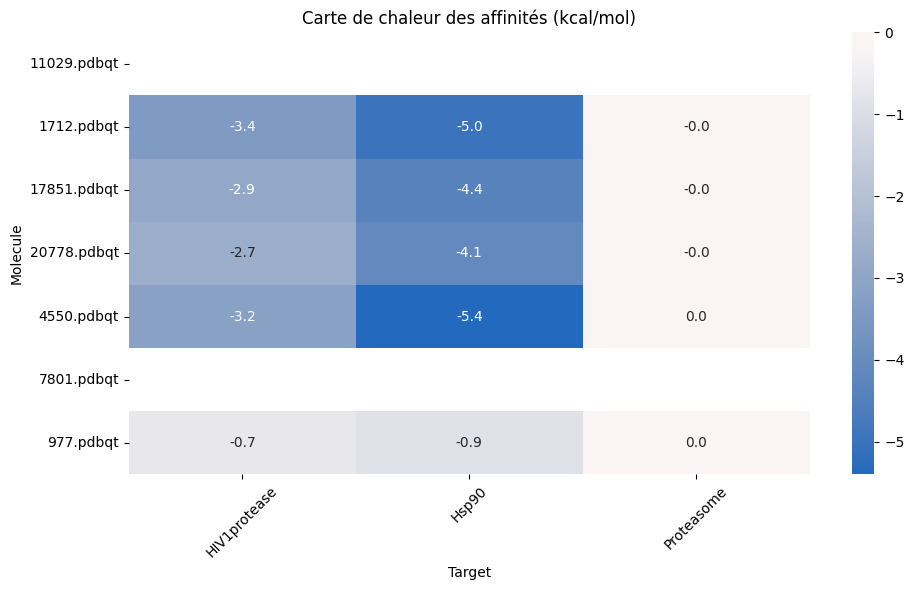

In [3]:
# Charger les résultats
df = pd.read_csv("docking_matrix.csv")

# Extraire les colonnes d’affinité
aff_cols = [col for col in df.columns if col not in ["Molecule"] and not col.endswith("_method")]
aff_data = df[["Molecule"] + aff_cols]

# Données format long
df_long = aff_data.melt(id_vars="Molecule", var_name="Target", value_name="Affinity")

# Plot
plt.figure(figsize=(10, 6))
heatmap_data = df_long.pivot(index="Molecule", columns="Target", values="Affinity")
sns.heatmap(heatmap_data, cmap="vlag", center=0, annot=True, fmt=".1f")
plt.title("Carte de chaleur des affinités (kcal/mol)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()